In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/santander_2016-master

/content/drive/My Drive/santander_2016-master


In [3]:
!pip install --upgrade lightgbm catboost

     |████████████████████████████████| 2.0 MB 12.5 MB/s 
     |████████████████████████████████| 76.3 MB 1.4 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold

%matplotlib inline

In [5]:
# path
metafolder_train = "data/output/train/"
metafolder_test = "data/output/test/"        
input_folder = "data/input/"
feature_folder = "data/output/features/"
model_name = "lightgbm"

In [6]:
data_train = pd.read_csv(input_folder + "train.csv")
data_test = pd.read_csv(input_folder + "test.csv")

In [7]:
data_train.shape

(76020, 371)

In [8]:
data_test.shape

(75818, 370)

# Tách input, output của tập train

In [9]:
X_train = data_train.drop(['ID', 'TARGET'], axis = 1)
y_train = data_train.TARGET

In [10]:
X_test = data_test.drop(['ID'], axis = 1)

# Khám phá dữ liệu

## Kiểu dữ liệu của các cột là gì?

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 369 entries, var3 to var38
dtypes: float64(111), int64(258)
memory usage: 214.0 MB


--> Các cột đều là kiểu dữ liệu số

## Tìm xem có giá trị nào còn thiếu không

In [12]:
X_train.isnull().values.any()

False

## Tìm xem cột nào trùng nhau

In [13]:
is_dup = X_train.T.duplicated().T
is_dup = is_dup.to_dict()

In [14]:
duplicated_cols = []

for col in is_dup:
  if (is_dup[col] == True):
    duplicated_cols.append(col)
  
print(len(duplicated_cols))
# duplicated_cols

62


## Tìm xem cột nào chỉ có 1 giá trị

In [15]:
col_list = []
for col in X_train.columns:
  if (col not in ['ID', 'TARGET']):
    col_list.append(col)
len(col_list)

369

In [16]:
unique_cols = []
for col in col_list:
  if (len(np.unique(X_train[col])) < 2):
    unique_cols.append(col)
print(len(unique_cols))
# unique_cols 

34


## Tiền xử lý dữ liệu cơ bản

Xóa các cột bị trùng nhau và các cột chỉ có 1 giá trị

In [17]:
drop_cols = set(duplicated_cols).union(set(unique_cols))
drop_cols = list(drop_cols)
print(len(drop_cols))
# drop_cols

63


In [18]:
X_train.drop(drop_cols, axis = 1, inplace = True)
X_train

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,...,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,...,0,0.00,88.89,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3.00,0.18,3.00,2.07,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,48,186.09,0.00,91.56,138.84,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,3.00,0.30,40501.08,13501.47,0.0,0.0,0.0,0.0,0.00,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000
76016,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,48,130.65,0.00,0.00,0.00,0.0,0.0,0.0,0.0,15498.42,0.0,48175.62,31837.02,0.0,0.00,0.0,0.00,0.0,0.0,0.0

In [19]:
X_test.drop(drop_cols, axis = 1, inplace = True)
X_test

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,...,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,6.0,2.43,6.00,4.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.100000
1,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,3.0,2.55,3.00,2.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.720000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,60.0,60.0,60.0,60.0,60.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9,90.0,57.00,51.45,66.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.950000
3,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.610000
4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,30.0,3.87,30.00,21.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.730000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75813,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40243.200000
75814,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3.0,1.23,3.00,2.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146961.300000
75815,2,24

# Khám phá chi tiết hơn về dữ liệu các cột

In [20]:
X_train.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,...,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04
mean,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.050855,0.023652,0.005301,0.001802,0.001447,...,13.651105,1579.135311,8.913659e+02,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05
std,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.219703,0.151962,0.072617,0.042414,0.038012,...,33.304012,12148.452398,9.888597e+03,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935

In [21]:
def value_counts(col):
  return dict(col.value_counts())

# số lượng giá trị, thống kê giá trị từng cột
cols_stat = X_train.agg([pd.Series.nunique, value_counts])
pd.set_option('display.max_colwidth', 10000)
cols_stat

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,...,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
nunique,208,100,596,7551,9099,293,346,23,29,224,7421,8961,331,454,8032,336,462,8149,66,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,172,14486,7787,14778,17330,1325,439,2116,2173,2834,1152,3405,3447,1628,968,943,2576,295,264,233,511,3,3,88,18,119,119,5,2,4,4,43,24,48,48,99,33,141,141,57736
value_counts,"{2: 74165, 8: 138, -999999: 116, 9: 110, 3: 108, 1: 105, 13: 98, 7: 97, 4: 86, 12: 85, 6: 82, 0: 75, 10: 72, 11: 66, 5: 63, 14: 61, 15: 34, 18: 10, 16: 9, 17: 7, 23: 7, 25: 6, 142: 6, 154: 6, 20: 6, 31: 6, 38: 6, 153: 5, 24: 5, 91: 5, 30: 5, 114: 5, 22: 5, 149: 5, 192: 5, 138: 5, 21: 4, 174: 4, 102: 4, 36: 4, 162: 4, 129: 4, 158: 4, 28: 4, 133: 4, 172: 4, 46: 4, 110: 4, 27: 4, 103: 4, 147: 4, 183: 4, 48: 4, 86: 4, 209: 4, 161: 3, 64: 3, 100: 3, 19: 3, 163: 3, 26: 3, 33: 3, 217: 3, 88: 3, 195: 3, 156: 3, 216: 3, 167: 3, 137: 3, 143: 3, 29: 3, 53: 3, 189: 3, 58: 3, 56: 3, 118: 3, 117: 3, 49: 3, 43: 3, 125: 3, 175: 3, 121: 3, 104: 3, 176: 2, 105: 2, 187: 2, 198: 2, 150: 2, 50: 2, 59: 2, 145: 2, 51: 2, 85: 2, 115: 2, 148: 2, 52: 2, 116: 2, 146: 2, 82: 2, 81: 2, ...}","{23: 20170, 24: 6232, 25: 4217, 26: 3270, 27: 2861, 28: 2173, 31: 1798, 29: 1727, 30: 1640, 32: 1592, 36: 1546, 35: 1536, 34: 1489, 37: 1401, 38: 1390, 33: 1377, 39: 1329, 40: 1310, 41: 1242, 42: 1199, 43: 1077, 44: 1042, 45: 1020, 22: 940, 46: 910, 47: 780, 48: 773, 49: 708, 50: 666, 51: 663, 52: 589, 53: 567, 54: 504, 55: 480, 56: 451, 57: 385, 58: 369, 59: 359, 60: 311, 61: 288, 62: 280, 64: 274, 63: 252, 65: 207, 67: 189, 70: 180, 66: 178, 68: 156, 69: 151, 71: 133, 72: 122, 74: 117, 75: 113, 76: 109, 73: 89, 79: 70, 78: 68, 77: 64, 80: 57, 83: 56, 84: 54, 82: 50, 88: 48, 81: 47, 85: 43, 86: 42, 89: 40, 87: 37, 91: 30, 5: 28, 15: 27, 90: 26, 21: 21, 6: 21, 93: 20, 14: 20, 11: 19, 9: 18, 10: 17, 92: 16, 19: 16, 18: 14, 17: 13, 16: 12, 94: 12, 13: 11, 12: 11, 20: 9, 8: 9, 96: 7, 7: 6, 95: 6, 99: 6, 100: 6, 102: 4, 97: 3, 104: 2, 98: 1, 105: 1, 101: 1}","{0.0: 72301, 300.0: 221, 150.0: 217, 600.0: 172, 900.0: 164, 3.0: 141, 450.0: 124, 60.0: 123, 1500.0: 119, 90.0: 112, 30.0: 97, 1200.0: 89, 3000.0: 76, 120.0: 74, 15.0: 65, 750.0: 61, 180.0: 56, 1800.0: 56, 210.0: 55, 360.0: 46, 1050.0: 42, 240.0: 42, 75.0: 31, 2400.0: 31, 6000.0: 29, 420.0: 29, 2100.0: 28, 270.0: 25, 480.0: 23, 660.0: 22, 390.0: 21, 1350.0: 21, 45.0: 21, 4500.0: 19, 9000.0: 19, 3600.0: 19, 2700.0: 18, 1650.0: 18, 9

## Tìm và xóa các cột có tỉ lệ số 0 chiếm chủ yếu (>= threshold)

In [22]:
def CalcSparse(col):
  num_zeros = (X_train[col] == 0).sum()
  return num_zeros / X_train.shape[0]

In [23]:
def PercentageZeros(data):
  perc = []
  for col in data.columns:
    percentage_zeros = CalcSparse(col)
    perc.append(percentage_zeros)
  return perc

In [24]:
zeros_perc = PercentageZeros(X_train)
print(len(zeros_perc))

306


In [25]:
# plot histogram of arr_data in range: [start, end), with step = stepp
def plot_hist(arr_data, start, end, stepp):
  bin_edges = np.arange(start, end, step = stepp)
  plt.hist(arr_data, bins = bin_edges)
  plt.xticks(bin_edges, rotation = 90)
  plt.tight_layout()
  plt.show()

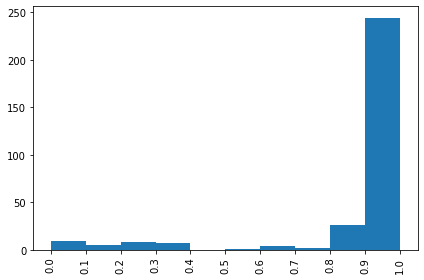

In [26]:
plot_hist(zeros_perc, 0, 1.1, 0.1)

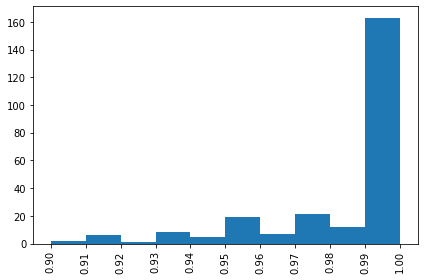

In [27]:
plot_hist(zeros_perc, 0.9, 1.01, 0.01)

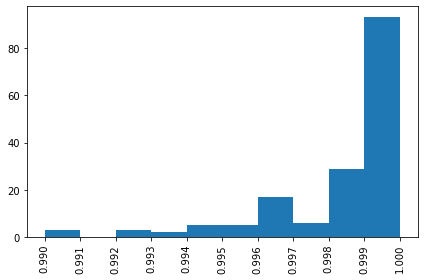

In [28]:
plot_hist(zeros_perc, 0.99, 1.001, 0.001)

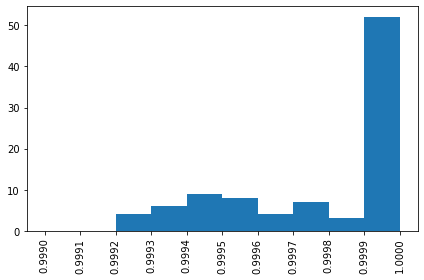

In [29]:
plot_hist(zeros_perc, 0.999, 1.0001, 0.0001)

In [30]:
def SparseCols(data, threshold):
  sparse_cols = []
  for col in data.columns:
    percentage_zero = CalcSparse(col)
    if (percentage_zero >= threshold):
      sparse_cols.append(col)
  return sparse_cols

In [31]:
threshold = 0.9999
sparse_cols = SparseCols(X_train, threshold)
print(len(sparse_cols))
# sparse_cols

52


In [32]:
X_train.drop(sparse_cols, axis = 1, inplace = True)
X_train.shape

(76020, 254)

In [33]:
X_test.drop(sparse_cols, axis = 1, inplace = True)
X_test.shape

(75818, 254)

## Dùng hàm features_importance để tìm ra độ quan trọng của các features

https://machinelearningmastery.com/calculate-feature-importance-with-python/

Lấy 5 features quan trọng nhất ra để tìm mối liên hệ giữa chúng sẽ ảnh hưởng thế nào đến TARGET. Từ các mối quan hệ đó ta sẽ có thể có xây dựng được những features mới

## Kiểm tra xem tập huấn luyện có bị mất cân bằng không

In [34]:
y_train.value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

--> Có bị mất cân bằng, tìm cách xử lý việc này

# Tiền xử lý dữ liệu

Setting pipeline để tiền xử lý cho tập train và val

## Xử lí dữ liệu nhiễu & outliers

## Chuẩn hóa dữ liệu

## Giảm chiều dữ liệu

## Cân bằng dữ liệu

### Phương pháp SMOTE + Edited Nearest Neighbors(ENN)

SMOTEENN

https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/

### Setting thuộc tính class_weight của model LightGBM hỗ trợ

# Mô hình hóa dữ liệu

## LightGBM

In [35]:
import lightgbm as lgb

## CatBoost

In [36]:
import catboost